In [1]:
import sys
import os

# If the notebook is in a subfolder (e.g. 'notebooks/'):
# Add the parent directory (the project root) to the path
if '..' not in sys.path:
    sys.path.append('..')

# If CWD is already the root directory, but 'src' is not found:
# Adds the current directory
if '.' not in sys.path:
    sys.path.append('.')

# 0. Import and Functions

In [3]:
# Data preparation packages
import pandas as pd
import numpy as np
import category_encoders as ce

# Graphics packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

# Models and metrics packages
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

# Auxiliary functions package
from src.a3data import preditiva

## 0.2 Loading Data

In [5]:
df = pd.read_csv('/Users/guedesf/Documents/Data Science/Projetos/a3data/data/curated/Customer-Churn_dummies.csv',
                 sep=';')
df.head()

,tenure,MonthlyCharges,TotalCharges,Churn,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,72,118.75,8672.45,False,True,True,True,False,False,True,...,False,True,False,True,False,True,True,False,False,False
1,71,118.65,8477.60,False,False,False,True,False,False,True,...,False,True,False,True,False,True,True,False,True,False
2,68,118.60,7990.05,False,True,False,True,False,False,True,...,False,True,False,True,False,True,False,False,False,True
3,61,118.60,7365.70,False,False,False,True,False,False,True,...,False,True,False,True,True,False,True,False,True,False
4,67,118.35,7804.15,True,False,False,True,False,False,True,...,False,True,False,True,True,False,True,False,False,False


# 1. Decision Tree Model

## 1.1 Train-Test Split

In [7]:
y = df['Churn']
X = df.drop('Churn', axis=1)

print(f"\nDimensões de X (features): {X.shape}")
print(f"Dimensões de y (alvo): {y.shape}")


Dimensões de X (features): (7043, 25)
Dimensões de y (alvo): (7043,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )

print("\n--- Divisão Concluída ---")
print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de X_test: {X_test.shape}")
print(f"Formato de y_train: {y_train.shape}")
print(f"Formato de y_test: {y_test.shape}")


--- Divisão Concluída ---
Formato de X_train: (5634, 25)
Formato de X_test: (1409, 25)
Formato de y_train: (5634,)
Formato de y_test: (1409,)


In [ ]:
# Check the stratification (Good practice)
print("\nVerificação da proporção de Churn (estratificação):")
print(f"Proporção no dataset original: {y.mean():.4f}")
print(f"Proporção no set de treino:   {y_train.mean():.4f}")
print(f"Proporção no set de teste:    {y_test.mean():.4f}")


Verificação da proporção de Churn (estratificação):
Proporção no dataset original: 0.2654
Proporção no set de treino:   0.2654
Proporção no set de teste:    0.2654


# 2. Machine Learning - Decision Tree

In [12]:
model_dt = DecisionTreeClassifier(random_state=42,
                                   class_weight='balanced')

model_dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [13]:
correct_features = list(X_train.columns)

# Number of features the model was trained on
n_features_in_model = model_dt.n_features_in_

# Number of feature names you provided
n_features_in_list = len(correct_features)

print(f"Model expects {n_features_in_model} features.")
print(f"You provided {n_features_in_list} feature names.")

# This condition is likely True in your case
if n_features_in_model != n_features_in_list:
    print("\n⚠️ There is a mismatch, which is causing the error.")

Model expects 25 features.
You provided 25 feature names.


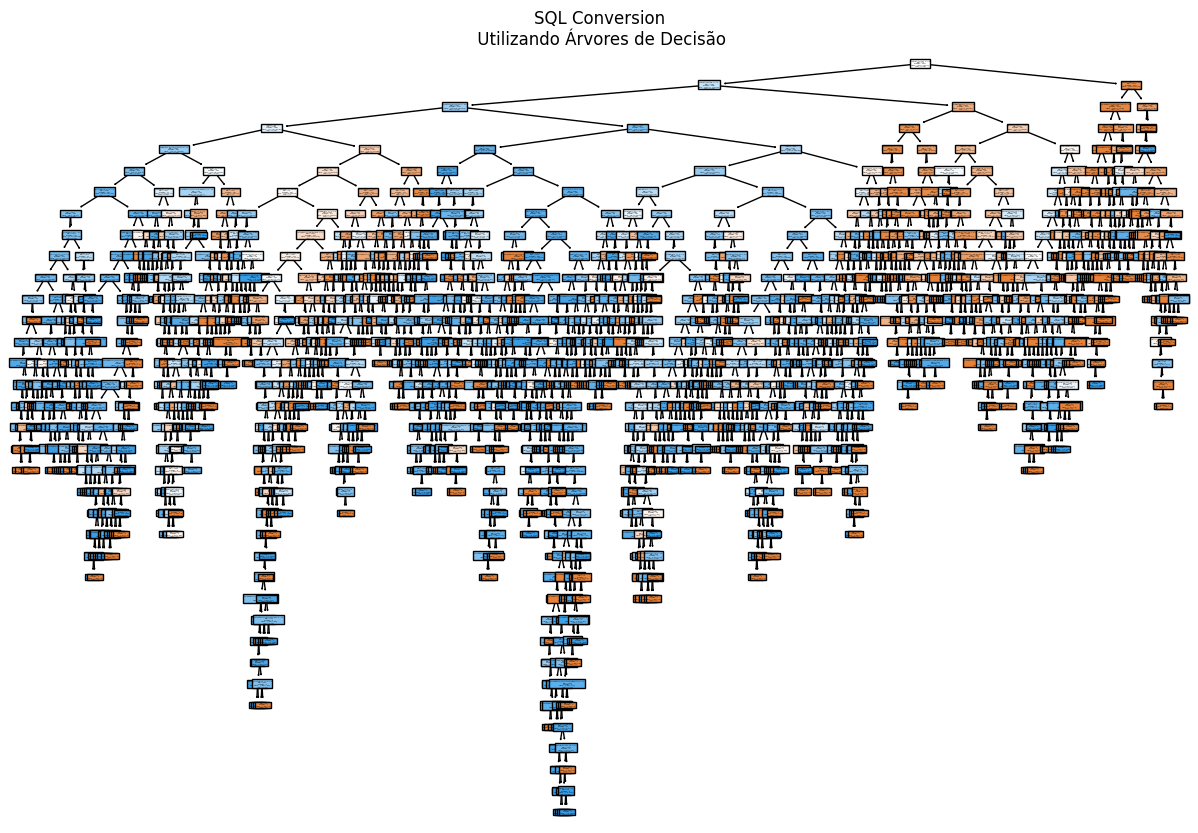

In [14]:
sns.reset_defaults()
%matplotlib inline
fig = plt.figure(figsize=(15,10))
tree.plot_tree(model_dt,
               feature_names=correct_features,
               class_names=['SQL','No SQL'],
               filled=True);
plt.title("SQL Conversion\n Utilizando Árvores de Decisão");

## 2.1 Model Performance

In [15]:
preditiva.calcula_desempenho(model_dt, X_train, y_train, X_test, y_test)

,Treino,Teste,Variação
Acurácia,0.996450,0.735983,-0.26
AUROC,0.999970,0.663554,-0.34
KS,0.993886,0.325637,-0.67
Precision,0.988734,0.502674,-0.49
Recall,0.997993,0.502674,-0.50
F1,0.995461,0.661482,-0.34


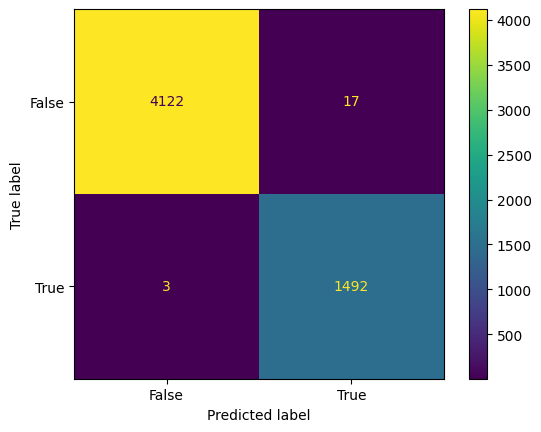

In [16]:
ConfusionMatrixDisplay.from_estimator(
        model_dt,
        X_train,
        y_train,
        display_labels=model_dt.classes_
    )

## 2.2 Cross-Validation and Hyperparameter Tuning

In [25]:
#Functions for the Optimization Cycle

def perform_grid_search(X_train_data, y_train_data, param_grid):
    """
    Performs GridSearchCV to find the best hyperparameters for a Decision Tree model.
    Now returns both training and validation scores for the best model.

    Args:
        X_train_data (pd.DataFrame): Training features.
        y_train_data (pd.Series): Training labels.
        param_grid (dict): Dictionary with hyperparameters and their possible values.

    Returns:
        sklearn.tree.DecisionTreeClassifier: The best model found by GridSearchCV.
        dict: The best hyperparameters.
        float: The best cross-validation score (validation score).
        float: The corresponding training score for the best model.
    """
    tree_model = DecisionTreeClassifier(random_state=42,
                                        class_weight='balanced')
    
    # MODIFICAÇÃO 1: Adicionar 'return_train_score=True'
    grid_search = GridSearchCV(
        tree_model, 
        param_grid, 
        cv=5, 
        scoring='recall', 
        return_train_score=True # Habilita o cálculo do score de treino
    )
    
    grid_search.fit(X_train_data, y_train_data)
    
    # MODIFICAÇÃO 2: Extrair o score de treino do melhor modelo
    best_model_index = grid_search.best_index_
    best_train_score = grid_search.cv_results_['mean_train_score'][best_model_index]
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_, best_train_score

In [26]:
max_depth_values = list(range(5, 12, 1))
min_samples_leaf_values = list(range(10, 30, 2))
min_samples_split_values = list(range(10, 30, 2))

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': max_depth_values,
    'min_samples_leaf': min_samples_leaf_values,
    'min_samples_split': min_samples_split_values
    }

best_model, best_hyperparams, best_validation_score, best_train_score = perform_grid_search(X_train, y_train, param_grid)

# Analise os resultados
print(f"Melhores Hiperparâmetros: {best_hyperparams}")
print(f"Melhor Recall de Validação (CV): {best_validation_score:.4f}")
print(f"Recall de Treino (para o melhor modelo): {best_train_score:.4f}")

Melhores Hiperparâmetros: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 10}
Melhor Recall de Validação (CV): 0.8207
Recall de Treino (para o melhor modelo): 0.8642


In [27]:
preditiva.calcula_desempenho(best_model, X_train, y_train, X_test, y_test)

,Treino,Teste,Variação
Acurácia,0.757898,0.751597,-0.01
AUROC,0.857830,0.826391,-0.04
KS,0.551665,0.504219,-0.09
Precision,0.528441,0.522388,-0.01
Recall,0.814047,0.748663,-0.08
F1,0.729133,0.715973,-0.02


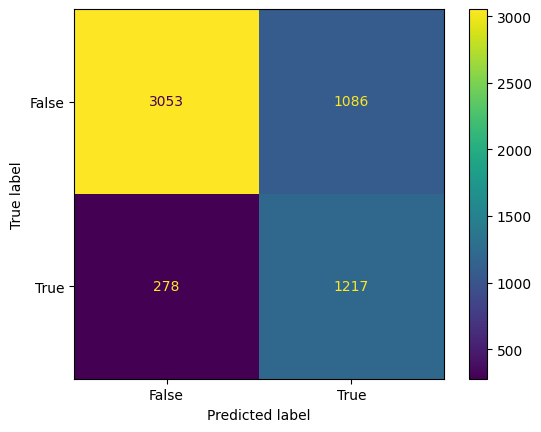

In [28]:
ConfusionMatrixDisplay.from_estimator(
        best_model,
        X_train,
        y_train,
        display_labels=best_model.classes_
    )

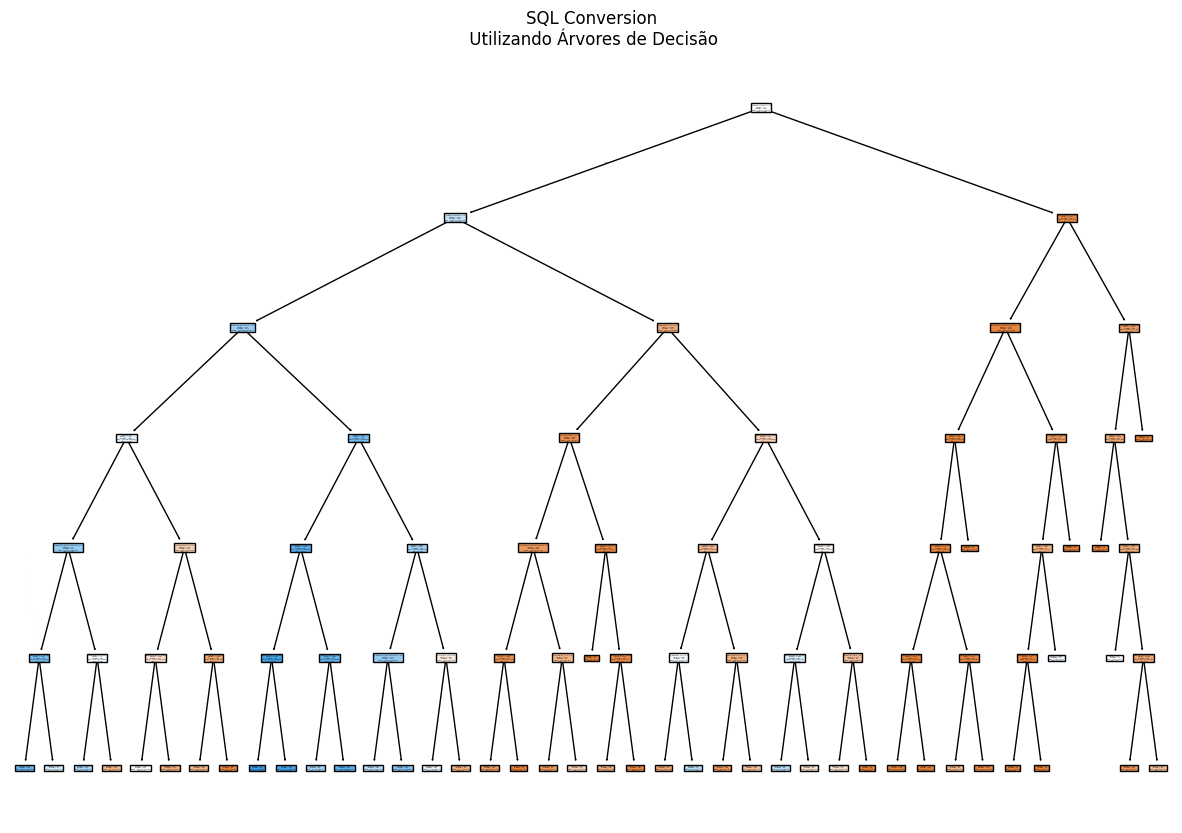

In [29]:
sns.reset_defaults()
%matplotlib inline
fig = plt.figure(figsize=(15,10))
tree.plot_tree(best_model,
               feature_names=correct_features,
               class_names=['SQL','No SQL'],
               filled=True);
plt.title("SQL Conversion\n Utilizando Árvores de Decisão");